**이미지 데이터 증강**  
<br>
이미지 데이터 증강 기법은 크게 회전, 대칭, 이동, 크기 조정 등이 있다.  
이론은 블로그 참고:
https://choiwonjin.tistory.com/56

이미지 증강 라이브러리 설치

In [1]:
# !pip install imgaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 18.9 MB/s eta 0:00:00


In [5]:
from matplotlib import pyplot as plt

from PIL import Image
from torchvision import transforms

In [6]:
image = Image.open("/content/cat.jpg")

torch.Size([3, 512, 512])


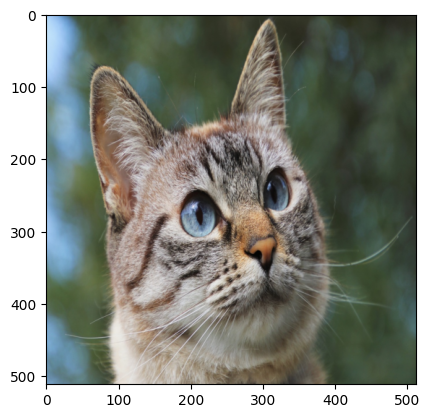

In [4]:
# 통합 클래스 및 변환 적용 방식
transform = transforms.Compose(
    [
        transforms.Resize(size=(512, 512)),     # 크기를 512 x 512로 변환
        transforms.ToTensor()                   # 텐서 타입으로 변환
    ]
)

transformed_image = transform(image)
print(transformed_image.shape)
plt.imshow(transformed_image.permute(1, 2, 0))

텐서화 클래스(transforms.ToTensor())는 [0 \~ 255] 범위의 픽셀값을 [0.0 \~ 1.0] 사이의 값으로 Min-Max Scaling을 진행한다.
또한, PIL 이미지(H x W x C) → 텐서(C x H x W)로 바꾼다.  
<br>
하지만 시각화 할 때, pyplot.imshow()는
이미지를 (H, W, C) 형태로 받기 때문에 (C x H x W) 를 다시 (H, W, C) 형태로 변환해서 시각화해야 한다.

# 회전 및 대칭

아래는 이미지를 -30도에서 30도 회전시키면서 수평 대칭과 수직 대칭을 50% 확률로 적용하는 코드이다.

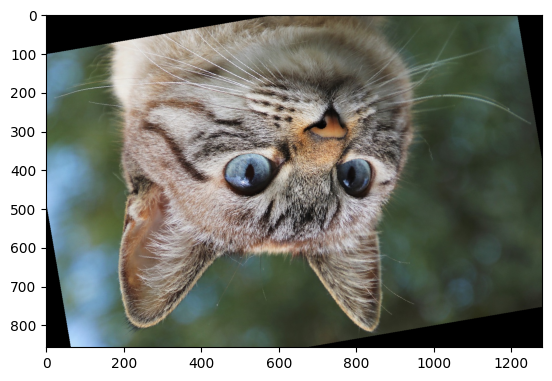

In [7]:
transform = transforms.Compose(
    [
        transforms.RandomRotation(degrees=30, expand=False, center=None),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5)
    ]
)

transformed_image = transform(image)
plt.imshow(transformed_image)

이미지를 회전하는 과정에서 여백이 생길 수 있는데 expand 값을 True로 하면 여백이 생성되지 않는다.  
중심점은 시퀀스 형태로 전달하며 입력하지 않으면 왼쪽 상단을 기준으로 회전한다.  
<br>
무작위 회전 클래스(RandomRotation)는 입력된 각도를 음수부터 양수 사이의 각도로 변환한다.  
임의의 범위를 설정하려면 [-30, 90]과 같이 시퀀스 형태로 입력한다.

# 자르기 및 패딩

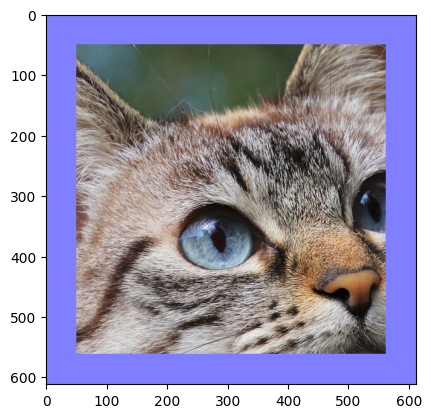

In [8]:
transform = transforms.Compose(
    [
        transforms.RandomCrop(size=(512, 512)),
        transforms.Pad(padding=50, fill=(127, 127, 255), padding_mode="constant")
    ]
)

transformed_image = transform(image)
plt.imshow(transformed_image)

무작위 자르기 클래스(RandomCrop)도 무작위 회전 클래스처럼 정수나 시퀀스 형태로 값을 입력할 수 있다.  
정수로 입력한다면 이미지의 높이와 너비가 동일한 정사각형 이미지로 잘리며, 시퀀스로 입력하는 경우 (높이, 너비) 순서로 이미지를 자른다.  
<br>
패딩 클래스(Pad)는 이미지 테두리에 특정한 방식이나 고정값으로 이미지를 확장하는 기능을 제공한다.  
512 X 512 크기로 자른 다음 50의 패딩을 주었는데, 패딩은 모든 방향으로 적용되므로 612 X 612 크기의 이미지로 변환된다.

# 변형

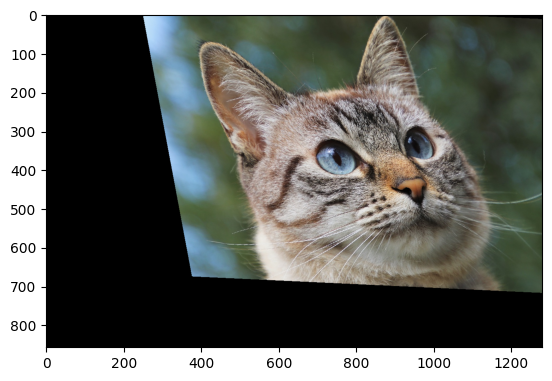

In [9]:
# 아핀 변환
transform = transforms.Compose(
    [
        transforms.RandomAffine(
            degrees=15, translate=(0.2, 0.2),
            scale=(0.8, 1.2), shear=15
        )
    ]
)

transformed_image = transform(image)
plt.imshow(transformed_image)

아핀 변환은 각도(degrees), 이동(translate), 척도(scale), 진단(shear)을 입력해 이미지를 변형한다.

# 색상 변환

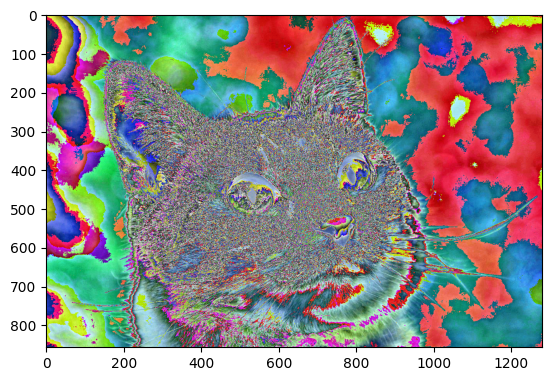

In [11]:
transform = transforms.Compose(
    [
        transforms.ColorJitter(
            brightness=0.3, contrast=0.3,
            saturation=0.3, hue=0.3
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
        ),
        transforms.ToPILImage()
    ]
)

transformed_image = transform(image)
plt.imshow(transformed_image)

색상 변환 클래스(ColorJitter)는 이미지의 밝기(brightness), 대비(constrast), 채도(saturation), 색상(hue)을 변환한다.  
간접적으로 데이터세트의 일반화 효과를 얻을 수 있으며, 객체 검출이나 인식 과정에서 색상보다는 형태가 중요한 경우 형태를 유지하면서 색상 톤을 낮출 수 있다.  
<br>
정규화 클래스(Normalize)는 PIL.Image 형식이 아닌 Tensor 형식을 입력으로 받는다.

# 노이즈

/tmp/ipython-input-207216906.py:5: UserWarning: Argument(s) 'slant_lower, slant_upper' are not valid for transform RandomRain
  A.RandomRain(p=0.7, slant_lower=-10, slant_upper=10),
/tmp/ipython-input-207216906.py:6: UserWarning: Argument(s) 'fog_coef_lower, fog_coef_upper' are not valid for transform RandomFog
  A.RandomFog(fog_coef_lower=0.2, fog_coef_upper=0.4, p=0.5),


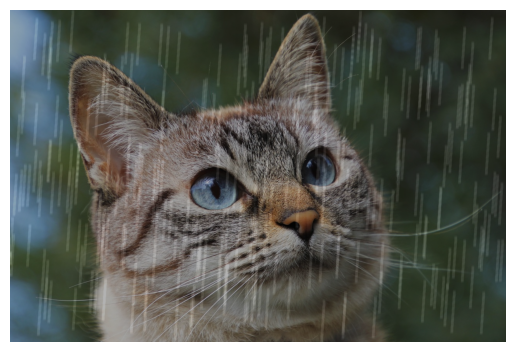

In [13]:
import albumentations as A # 이미지 증강 라이브러리
import numpy as np

transform = A.Compose([
    A.RandomRain(p=0.7, slant_lower=-10, slant_upper=10),
    A.RandomFog(fog_coef_lower=0.2, fog_coef_upper=0.4, p=0.5),
    A.ISONoise(p=0.3)
])

image = np.array(Image.open("/content/cat.jpg"))
augmented = transform(image=image)["image"]

plt.imshow(augmented)
plt.axis('off')
plt.show()

A.RandomRain(): 비 내리는 효과 추가  
slant_lower, slant\_lower로 빗줄기의 기울기 범위를 지정한다.  
A.RandomFog(): 안개 효과 추가.  
A.ISONoise(): ISO 카메라 노이즈 추가

# 컷아웃(Cutout) 및 무작위 지우기(Random Erasing)

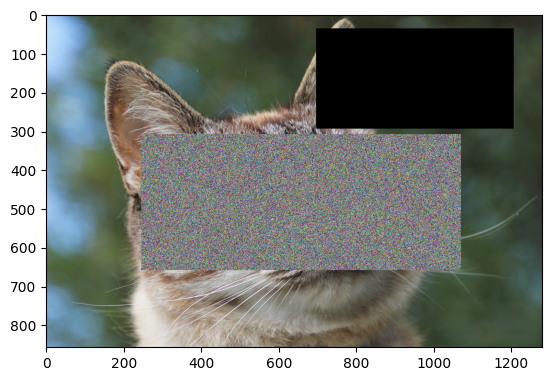

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomErasing(p=1.0, value=0),        # Cutout
    transforms.RandomErasing(p=1.0, value='random'), # Random Erasing
    transforms.ToPILImage()
])

transformed_image = transform(image)
plt.imshow(transformed_image)

무작위 지우기 클래스(RandomErasing)는 Tensor 형식만 지원되므로 해당 클래스를 호출하기 전에 텐서 변환 클래스를 호출해 Tensor 형식으로 변환해야 한다.

# 혼합(Mixup) 및 컷믹스(Cutmix)

### Mixup

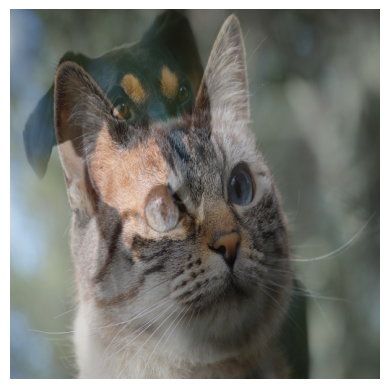

In [19]:
import albumentations as A

class MixupAlb:
    def __init__(self, target, alpha=0.5, beta=0.5):
        self.target = target
        self.alpha = alpha
        self.beta = beta

    def __call__(self, image):
        image = np.array(image)
        target = np.array(self.target.resize(image.shape[:2][::-1])) # 두 이미지의 가중합 계산
        mix_image = image * self.alpha + target * self.beta
        return mix_image.astype(np.uint8)

transform = A.Compose([
    A.Resize(512, 512),
])

image_resized = transform(image=image)["image"]
mix_image = MixupAlb(Image.open("/content/dog.jpg"))(image_resized)

plt.imshow(mix_image)
plt.axis('off')
plt.show()

albumentations는 NumPy 배열 기반 이미지 증강에 최적화되어 있고, torchvision.transforms보다 유연하다.  

target: 합성할 두 번째 이미지  
alpha, beta: 두 이미지의 가중치 (합성 비율)

### Cutmix

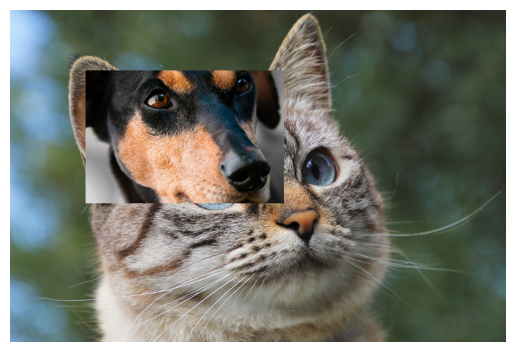

In [41]:
class CutMix:
    def __init__(self, target, alpha=0.5):
        """
        target: 덮어씌울 이미지 (PIL.Image)
        alpha: 덮어씌우는 영역 비율 (0~1)
        """
        self.target = target
        self.alpha = alpha

    def __call__(self, image):
        """
        image: 원본 이미지 (PIL.Image 또는 NumPy 배열)
        """
        if isinstance(image, Image.Image):
            image = np.array(image)

        target = np.array(self.target.resize(image.shape[:2][::-1]))

        # CutMix 영역 설정
        h, w, _ = image.shape
        cut_h = int(h * self.alpha)
        cut_w = int(w * self.alpha)
        y1 = np.random.randint(0, h - cut_h)
        x1 = np.random.randint(0, w - cut_w)
        y2 = y1 + cut_h
        x2 = x1 + cut_w

        # 원본 이미지에 target 이미지 일부 덮어씌우기
        image[y1:y2, x1:x2] = target[y1:y2, x1:x2]

        return image.astype(np.uint8)


image1 = Image.open("/content/cat.jpg")  # 원본 이미지
image2 = Image.open("/content/dog.jpg")  # 덮어씌울 이미지

cutmix_transform = CutMix(target=image2, alpha=0.4)
cutmix_image = cutmix_transform(image1)

plt.imshow(cutmix_image)
plt.axis('off')
plt.show()